In [1]:
import pandas as pd
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
from nltk.corpus import stopwords
from collections import Counter
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("font", size=18)
mpl.rcParams["font.family"] = "Liberation Serif"

In [2]:
# https://insights.stackoverflow.com/survey/2020#technology-most-loved-dreaded-and-wanted-languages-loved
loved_languages = {
    "rust":        86.1,
    "typescript":  67.1,
    "python":      66.7,
    "kotlin":      62.9,
    # "go":          62.3,
    # "julia":       62.2,
    # "dart":        62.1,
    # "c#":          59.7,
    # "swift":       59.5,
    # "javascript":  58.3,
    # "scala":       53.2,
    # "haskell":     51.7,
    # "r":           44.5,
    # "java":        44.1,
    # "c++":         43.4,
    # "ruby":        42.9,
    # "php":         37.3,
    # "c":           33.1,
    # "assembly":    29.4,
    # "perl":        28.6,
    # "objective-c": 23.4,
    # "vba":         19.6,
}

In [3]:
# Collect all data into single dataframe

def lang(fpath: str) -> str:
    # Get programming language from a filepath
    return "-".join(fpath[fpath.index("/")+1:].split("-")[:-1])

qdfs = list()
adfs = list()
cdfs = list()
for qf, af, cf in tqdm(zip(glob("data/*-questions.pkl"), glob("data/*-answers.pkl"), glob("data/*-comments.pkl")), total=len(loved_languages)):
    qdfs.append(pd.read_pickle(qf))
    qdfs[-1]["language"] = lang(qf)
    qdfs[-1]["type"] = "q"
    adfs.append(pd.read_pickle(af))
    adfs[-1]["language"] = lang(af)
    adfs[-1]["type"] = "a"
    cdfs.append(pd.read_pickle(cf))
    cdfs[-1]["language"] = lang(cf)
    cdfs[-1]["type"] = "c"
# Shuffle to prevent systematic biases in contiguous subsets of dataframe
so = pd.concat(qdfs + adfs + cdfs, ignore_index=True).sample(frac=1)
del qdfs, adfs, cdfs

10it [00:00, 10.18it/s]


In [4]:
# Data summary
t = Table()
t.add_row(["Language", "Questions", "Answers", "Comments", "Total"])
for lang in loved_languages:
    t.add_row([
        lang.capitalize(),
        *[thousand_seps(sum((so["language"] == lang) & (so["type"] == t))) for t in ("q", "a", "c")],
        thousand_seps(sum(so["language"] == lang)),
    ], [1, 0, 0, 0, 0])
t.add_row([
    "",
    thousand_seps(sum(so["type"] == "q")),
    thousand_seps(sum(so["type"] == "a")),
    thousand_seps(sum(so["type"] == "c")),
    thousand_seps(len(so)),
], [1, 0, 0, 0, 0])
print(t)
so

Language   | Questions | Answers | Comments | Total  
Rust       |    12,968 |  16,526 |   25,362 |  54,856
Typescript |    15,953 |  25,381 |   26,942 |  68,276
Python     |    26,100 |  47,627 |   53,072 | 126,799
Kotlin     |     9,387 |  15,443 |   17,034 |  41,864
           |   179,475 | 284,758 |  362,283 | 826,516


,language,body,question_id,link,owner/user_id,score,view_count,owner/reputation,creation_date,title,type
57119,python,<p>I'm currently working on computing a numeri...,43925780,https://stackoverflow.com/questions/43925780/n...,3738320,1,1068,175,1494537832,Nesting numerical integrals in python,q
723880,c#,Code please ...,56889847,NaN,1544545,5,NaN,169,1562249840,NaN,c
646895,objective-c,i am just using this method to setup the database,44940424,NaN,4955401,0,NaN,1389,1499320147,NaN,c
45711,python,"<p>I have the following function, which has be...",14059558,https://stackoverflow.com/questions/14059558/w...,751241,9,37566,908,1356633623,Why is python no longer waiting for os.system ...,q
319,dart,<p>I'm trying to convert the following Node.js...,13372083,https://stackoverflow.com/questions/13372083/n...,595936,0,245,7404,1352859375,NodeJs requests callbacks in Dart,q
...,...,...,...,...,...,...,...,...,...,...,...
236656,objective-c,"<p>The same of ""sad tuna"" but in <strong>Swift...",15822610,NaN,445772,1,NaN,14271,1472051637,NaN,a
321936,python,<p>I think you could do</p>\n\n<pre><code>[lin...,3260427,NaN,56541,10,NaN,115407,1279231494,NaN,a
293510,vba,"<p>Explicitly specify <code>Upper Case</code>,...",14025326,NaN,1389394,1,NaN,13499,1356379809,NaN,a
504507,python,What did you try? You should post your best ef...,36073691,NaN,21945,0,NaN,74509,1458259483,NaN,c


In [5]:
# Regex for matching stopwords
sw = r"\b(" + "|".join(stopwords.words("english")) + r")\b"

def clean(text: str) -> str:
    # Remove link sections
    text = re.sub(r"<pre><code>.*<\/pre><\/code>", "", text)
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    return text

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("Before cleaning")
print("  Words:         %s" % thousand_seps(words))
print("  Avg. per sub.: %.2f" % (words / len(so)))
print("  Characters:    %s" % thousand_seps(chars))
print("  Avg. per sub.: %.2f" % (chars / len(so)))

print("\nCleaning text")
so.body = [clean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("\nAfter cleaning")
print("  Words:         %s" % thousand_seps(words))
print("  Avg. per sub.: %.2f" % (words / len(so)))
print("  Characters:    %s" % thousand_seps(chars))
print("  Avg. per sub.: %.2f" % (chars / len(so)))

  0%|          | 889/826516 [00:00<01:32, 8883.21it/s]Before cleaning
  Words:         68,277,540
  Avg. per sub.: 82.61
  Characters:    572,511,744
  Avg. per sub.: 692.68

Cleaning text
100%|██████████| 826516/826516 [01:22<00:00, 10039.88it/s]

After cleaning
  Words:         46,752,077
  Avg. per sub.: 56.57
  Characters:    430,689,677
  Avg. per sub.: 521.09


<ipython-input-6-9be58e316a4c>:2: RuntimeWarning: divide by zero encountered in log10
  def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):


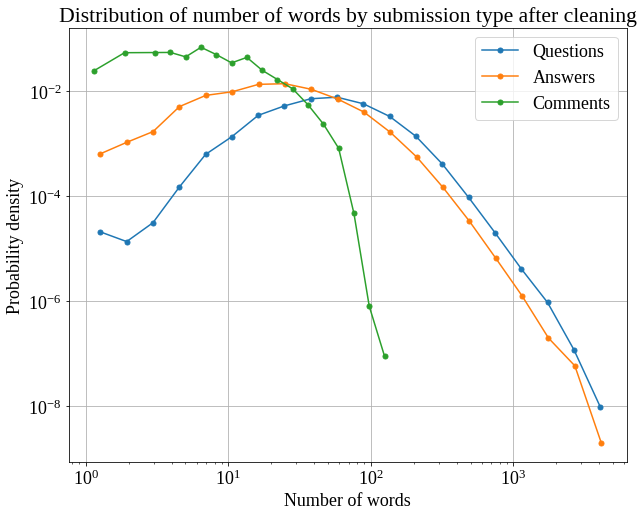

In [6]:
# Plot distribution of words
def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy

qx, qdist = bins(np.array([len(body.split()) for body in so.body[so.type=="q"]]))
ax, adist = bins(np.array([len(body.split()) for body in so.body[so.type=="a"]]))
cx, cdist = bins(np.array([len(body.split()) for body in so.body[so.type=="c"]]))

fig, ax_ = plt.subplots(figsize=(10, 8))
ax_.plot(qx, qdist, marker=".", ms=10, label="Questions")
ax_.plot(ax, adist, marker=".", ms=10, label="Answers")
ax_.plot(cx, cdist, marker=".", ms=10, label="Comments")
ax_.grid(True)
ax_.set_xscale("log")
ax_.set_yscale("log")
ax_.set_title("Distribution of number of words by submission type after cleaning")
ax_.set_xlabel("Number of words")
ax_.set_ylabel("Probability density")
ax_.legend()

In [12]:
# Combine texts by programming language
# FIXME
texts = { lang: list(itertools.chain(body.split() for body in so.body[so.language==lang])) for lang in tqdm(loved_languages) }


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]126799



In [8]:
tfidf = dict()  # { language: { word: TF-IDF score } }
counts = { lang: Counter(texts[lang]) for lang in loved_languages }
for lang in tqdm(loved_languages):
    c = counts[lang]
    freq[stock] = dict(c)
    tf[stock] = {word: count / len(stocks[stock]) for word, count in c.items() if word != stock.lower()}
    idf[stock] = {
        word: np.log(
            len(chosen_stocks) /\
            (1 + sum(word in counts[s] for s in stocks))
        )
        for word in c if word != stock.lower()
    }
    tfidf[stock] = { word: tf[stock][word] * idf[stock][word] for word in c if word != stock.lower() }

NameError: name 'stocks' is not defined